In [172]:
import pandas as pd
import numpy as np
import tweepy as tw
import jsonlines
import math
import copy
import pickle5
import matplotlib.pyplot as plt
import matplotlib
from nltk.sentiment import SentimentIntensityAnalyzer
np.set_printoptions(suppress=True)
import scipy.stats as stats
from fn import getRetweetsFavsFollowersInfo, getTagsMediaHashtagsInfo, retrieveFileNames, processCountsArray

In [2]:
# import news dataset
df_true = pd.read_pickle("true_roots_df_final.pkl")
df_fake = pd.read_pickle("fake_roots_df_final.pkl")

In [3]:
# import one day's worth of Chen's dataset
chen_125 = pd.read_pickle("01_25_trun.pkl")
chen_125_OG = chen_125[chen_125['isRT'] == False]

In [4]:
# import Chen's viral dataset
with open("viral_OG_tweets_5000.pkl", "rb") as f:
    viral_tweets = pickle5.load(f)
viral_tweets = viral_tweets[(viral_tweets['date'] < '2021-02-12')]
viral_tweets = viral_tweets.sort_values(['#Retweets'], ascending = False).reset_index()
chen_viral = viral_tweets.head(100)

In [5]:
# import Shahi datasets
df_shahi_I = pd.read_pickle("shahi_dataset-I.pkl")
df_shahi_II = pd.read_pickle("shahi_dataset-II_old.pkl")

In [6]:
# import ArCOV dataset
df_ArCOV_real = pd.read_pickle("ArCOV_real.pkl")
df_ArCOV_false = pd.read_pickle("ArCOV_fake.pkl")

In [7]:
# import CHECKED dataset
df_checked_real = pd.read_pickle("checked_real.pkl")
df_checked_false = pd.read_pickle("checked_fake.pkl")

In [199]:
# import Patwa dataset
f = jsonlines.open("Patwa Text.jsonl",)
for line in f.iter():
    patwa_all = line
patwa_real_text = patwa_all['real_text']
patwa_fake_text = patwa_all['fake_text']

## Auxiliary Functions

In [170]:
# sets log(1) = 0.01 instead of 0 so that it can be distinguished from log(0)
def takeLog(arr):
    result = np.log(arr)
    for i in range(len(result)):
        if (result[i] == 0):
            result[i] = 0.01
    return result
def plotScatters(arr, xlabel, ylabel, legend, lines=True, title=None, fontsize=22, ticksize=22):
    plt.figure(figsize=(12,8))
    color = ['b','r','g']
    for i in range(len(arr)):
        x = arr[i][0]
        y = arr[i][1]
        plt.scatter(x, y, c=color[i])
        if lines:
            m, b = np.polyfit(x, y, 1)
            print("m,b =",m,b)
            plt.plot(x, [m*q + b for q in x], c=color[i])
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    if (title != None):
        plt.title(title,fontsize=fontsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    if (legend != None):
        plt.legend(legend, fontsize=14)
def plotHistogram(arr, xlabel,density=False, fitGaussian=False, title=None, fontsize=22, ticksize=22, bins=None):
    plt.figure(figsize=(12,8))
    plt.hist(arr, density=density, bins=bins)
    if fitGaussian:
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        mean,std=stats.norm.fit(arr)
        y = stats.norm.pdf(x, mean, std)
        plt.plot(x, y, label="Gaussian Fit")
        plt.legend(fontsize=14)
    plt.xlabel(xlabel,fontsize=fontsize)
    if density:
        plt.ylabel("Density",fontsize=fontsize)
    else:
        plt.ylabel("Frequency",fontsize=fontsize)
    matplotlib.rc('font', size = fontsize)
    if (title != None):
        plt.title(title,fontsize=fontsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
def plotHistograms(arr,labels,xlabel,density=False,title=None, fontsize=22, ticksize=22, bins=None):
    plt.figure(figsize=(12,8))
    for i in range(len(arr)):
        plt.hist(arr[i], alpha=0.5, label=labels[i], density=density, bins=bins)
    if density:
        plt.ylabel("Density",fontsize=fontsize)
    else:
        plt.ylabel("Frequency",fontsize=fontsize)
    plt.legend(fontsize=14)
    plt.xlabel(xlabel,fontsize=fontsize)
    matplotlib.rc('font', size = fontsize)
    if (title != None):
        plt.title(title,fontsize=fontsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
def plotLines(arr, xlabel, ylabel, legend, title=None, fontsize=22, ticksize=22):
    plt.figure(figsize=(12,8))
    for i in range(len(arr)):
        x = arr[i][0]
        y = arr[i][1]
        plt.plot(x, y)
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    if (title != None):
        plt.title(title,fontsize=fontsize)
    if (legend != None):
        plt.legend(legend, fontsize=14)
def removeZeros(arr):
    temp = copy.deepcopy(arr)
    #temp = arr.copy()
    count = 0
    while (count < len(temp[0])):
        slice_arr = []
        for i in range(len(temp)):
            slice_arr.append(temp[i][count])
        if 0 in slice_arr:
            for i in range(len(temp)):
                del temp[i][count]
        else:
            count += 1
    return temp
def changeInfinityToZero(arr):
    temp = copy.deepcopy(arr)
    for i in range(len(arr)):
        if temp[i] == -math.inf:
            temp[i] = 0
    return temp
# function for calculating the linear regression between two variables, and 
# outputting the results
def runRegression(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("Regression Statistics: ")
    print("Slope: " + "{0:0.8f}".format(slope))
    print("Intercept: " + "{0:0.8f}".format(intercept))
    print("R-squared: " + "{0:0.8f}".format(r_value ** 2))
    print("p-value: " + "{0:0.8f}".format(p_value))
    print("Std error: " + "{0:0.8f}".format(std_err))
    print("Slope 95% LB: " + "{0:0.8f}".format(slope - 1.96* std_err))
    print("Slope 95% UB: " + "{0:0.8f}".format(slope + 1.96* std_err))
    return [slope, intercept, r_value, p_value, std_err]
# https://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/comparing-slopes-two-independent-samples/
def testSlopeDifference(x1, y1, x2, y2):
    slope1 = stats.linregress(x1, y1).slope
    se1 = stats.linregress(x1, y1).stderr
    slope2 = stats.linregress(x2, y2).slope
    se2 = stats.linregress(x2, y2).stderr
    se_diff = np.sqrt(se1**2 + se2**2)
    t_stat = (slope1-slope2)/se_diff
    print("Test statistic:",t_stat)
    print("Standard error:", se_diff)
    df = len(x1) + len(x2) - 4
    p_val = stats.t.cdf(-t_stat,df)
    print("P-value:",p_val)
    return t_stat, se_diff, p_val
def getResiduals(x, y):
    m, b = np.polyfit(x, y, 1)
    residuals = np.zeros(len(x))
    for i in range(len(x)):
        ypred = m*x[i] + b
        residuals[i] = y[i]-ypred
    return residuals
def getFolsFavsAndRetInfo(arr):
    og = []
    log = []
    for i in range(len(arr)):
        og = arr
        log.append(changeInfinityToZero(takeLog(og[i]).tolist()))
    noZeros = removeZeros(log)
    return [og, log, noZeros]
def getCountsTimeSeries(file_batch, normalized=True, lengthMin=0):
    file_names = retrieveFileNames(file_batch,lengthMin=lengthMin)
    counts = processCountsArray(file_names)
    counts_time = []
    for i in range(len(counts[0])):
        counts_time.append(sum(np.array(counts)[:,i]))
    if normalized:
        counts_time = counts_time/sum(counts_time)
    return counts_time
def testProportionDifference(p1, p2, n1, n2):
    p = p1*n1/(n1+n2) + p2*n2/(n1+n2)
    z = (p1-p2)/math.sqrt(p*(1-p)*(1/n1+1/n2))
    p_val = 2 * stats.norm.cdf(-abs(z))
    return p_val
def getNLTKPolarity(arr):
    sia = SentimentIntensityAnalyzer()
    neg = []
    neu = []
    pos = []
    comp = []
    for i in range(len(arr)):
        result = sia.polarity_scores(arr[i])
        neg.append(result['neg'])
        neu.append(result['neu'])
        pos.append(result['pos'])
        comp.append(result['compound'])
    return [neg, neu, pos, comp]

## Number of Followers and Retweets

In [9]:
chen_fol = chen_125_OG['#Followers'].tolist()
chen_ret = chen_125_OG['#Retweets'].tolist()
chen_fav = chen_125_OG['#Favorites'].tolist()
chen_viral_fol = chen_viral['#Followers'].tolist()
chen_viral_ret = chen_viral['#Retweets'].tolist()
chen_viral_fav = chen_viral['#Favorites'].tolist()
chen_data = getFolsFavsAndRetInfo([chen_fol, chen_ret, chen_fav])
chen_data_viral = getFolsFavsAndRetInfo([chen_viral_fol, chen_viral_ret, chen_viral_fav])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


0.006920272856435499


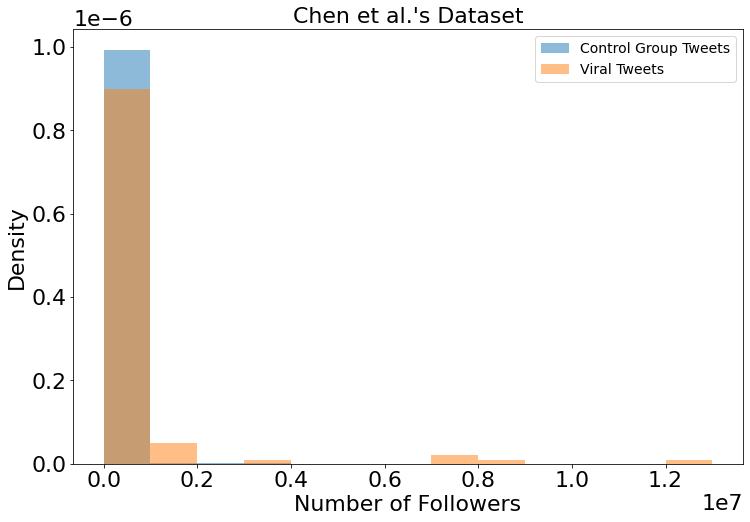

In [225]:
data = [chen_data[0][0], chen_data_viral[0][0]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Followers",True,"Chen et al.'s Dataset", bins=[10**7*x for x in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3]])
statistic, pvalue = stats.ttest_ind(data[0], data[1], equal_var=False, alternative='less')
print(pvalue)

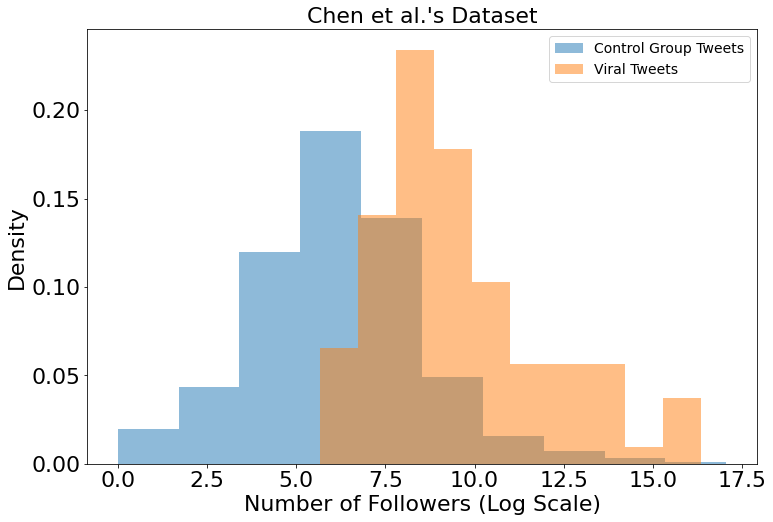

In [226]:
data = [chen_data[1][0], chen_data_viral[1][0]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Followers (Log Scale)",True, "Chen et al.'s Dataset")

3.440176173348212e-30


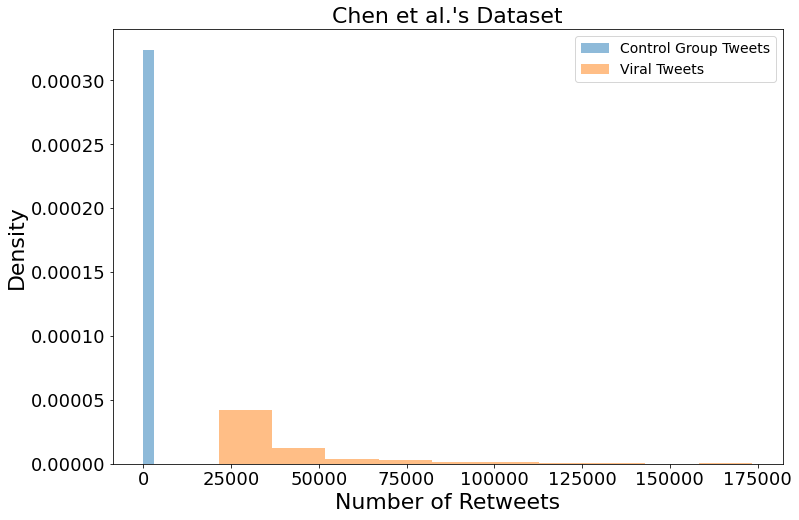

In [227]:
data = [chen_data[0][1], chen_data_viral[0][1]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Retweets",True, "Chen et al.'s Dataset", 22, 18)
statistic, pvalue = stats.ttest_ind(data[0], data[1], equal_var=False, alternative='less')
print(pvalue)

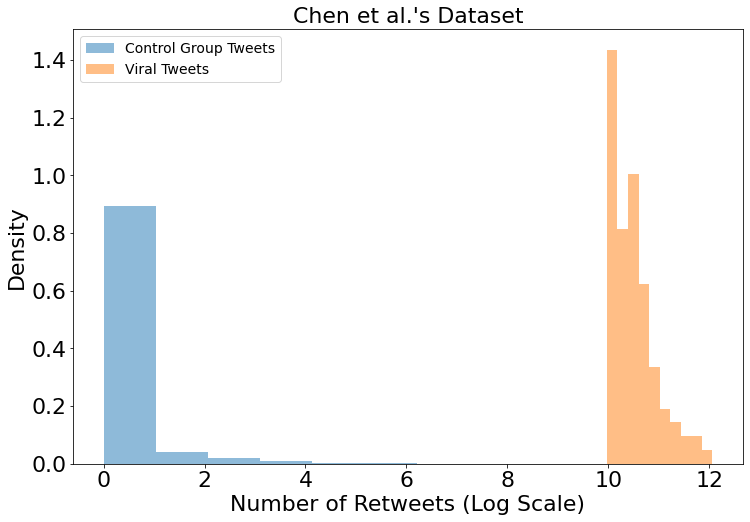

In [228]:
data = [chen_data[1][1], chen_data_viral[1][1]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Retweets (Log Scale)",True, "Chen et al.'s Dataset")

9.324712376861089e-21


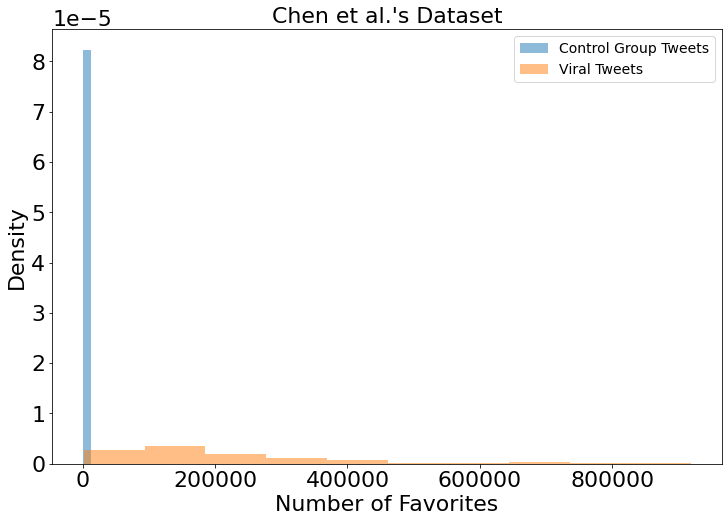

In [229]:
data = [chen_data[0][2], chen_data_viral[0][2]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Favorites",True, "Chen et al.'s Dataset", 22, 22)
statistic, pvalue = stats.ttest_ind(data[0], data[1], equal_var=False, alternative='less')
print(pvalue)

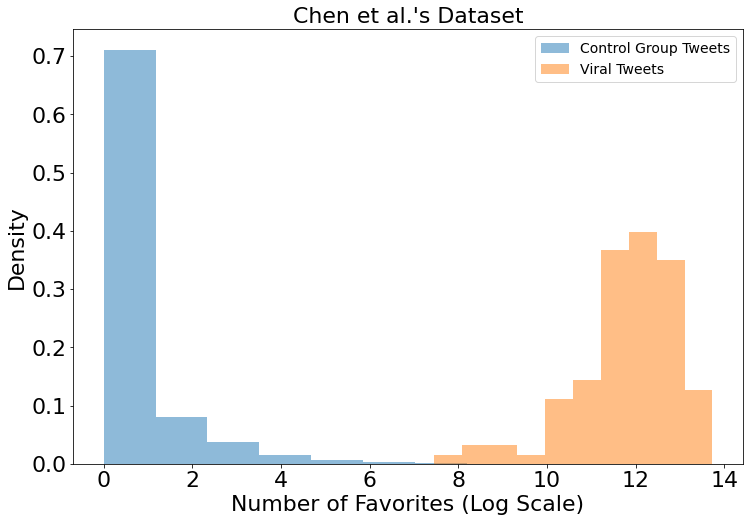

In [230]:
data = [chen_data[1][2], chen_data_viral[1][2]]
labels = ["Control Group Tweets", "Viral Tweets"]
plotHistograms(data,labels,"Number of Favorites (Log Scale)",True, "Chen et al.'s Dataset")

m,b = 0.2110633531660492 -0.6676747872998199
m,b = -0.01872002800513978 10.68123569047155


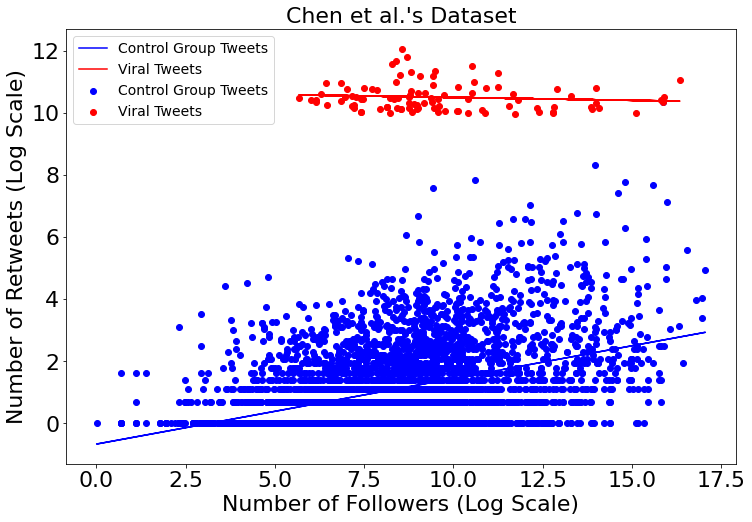

In [231]:
plot_arr = [chen_data[2][0], chen_data[2][1]], [chen_data_viral[2][0], chen_data_viral[2][1]]
legend = ['Control Group Tweets','Viral Tweets','Control Group Tweets','Viral Tweets']
plotScatters(plot_arr,'Number of Followers (Log Scale)', 'Number of Retweets (Log Scale)', legend, True, "Chen et al.'s Dataset")

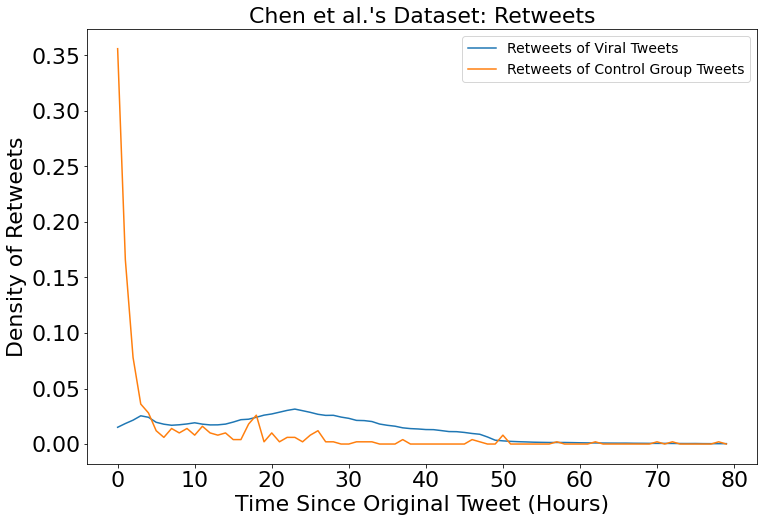

In [232]:
counts_viral_time = getCountsTimeSeries("viral_counts")
counts_control_time = getCountsTimeSeries("Chen_RTs5",lengthMin=14)
x = [q for q in range(len(counts_control_time))]
cutoff = 80
plot_arr = [[x[:cutoff],counts_viral_time[:cutoff]],
            [x[:cutoff],counts_control_time[:cutoff]]]
plotLines(plot_arr, "Time Since Original Tweet (Hours)", "Density of Retweets",["Retweets of Viral Tweets", "Retweets of Control Group Tweets"], "Chen et al.'s Dataset: Retweets")

## Retweets, Favorites, Followers

In [10]:
news_true_fol = df_true['#Followers']
news_true_ret = df_true['#Retweets']
news_true_fav = df_true['#Favorites']
news_false_fol = df_fake['#Followers']
news_false_ret = df_fake['#Retweets']
news_false_fav = df_fake['#Favorites']
news_true_data = getFolsFavsAndRetInfo([news_true_fol, news_true_ret, news_true_fav])
news_false_data = getFolsFavsAndRetInfo([news_false_fol, news_false_ret, news_false_fav])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.7339950009723493


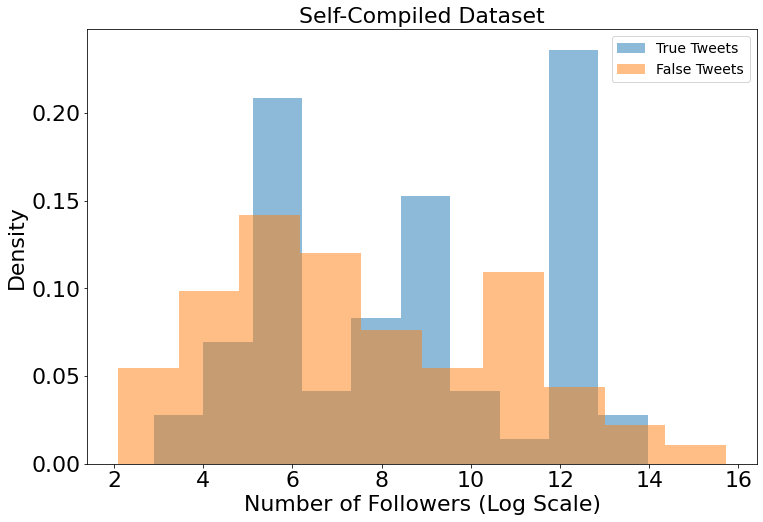

In [150]:
data = [news_true_data[1][0], news_false_data[1][0]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Followers (Log Scale)",True, "Self-Compiled Dataset")
statistic, pvalue = stats.ttest_ind(news_true_data[0][0], news_false_data[0][0], equal_var=False, alternative='two-sided')
print(pvalue)

0.021119651785666802


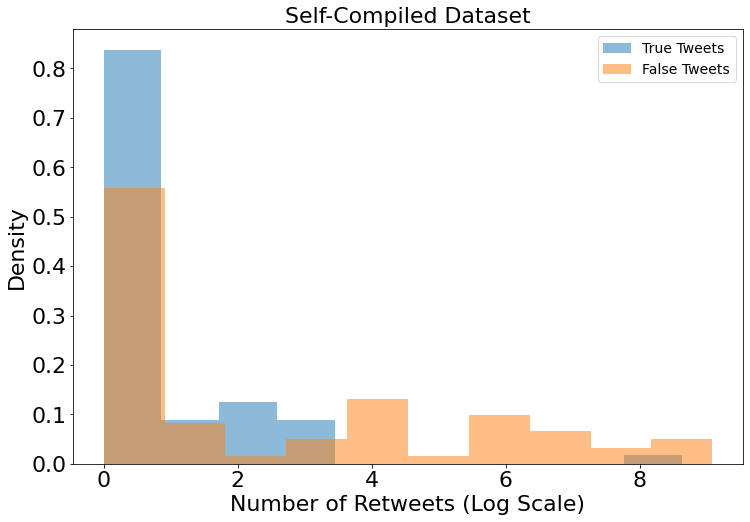

In [75]:
data = [news_true_data[1][1], news_false_data[1][1]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Retweets (Log Scale)",True, "Self-Compiled Dataset")
statistic, pvalue = stats.ttest_ind(news_true_data[0][1], news_false_data[0][1], equal_var=False, alternative='less')
print(pvalue)

0.2680013404842698


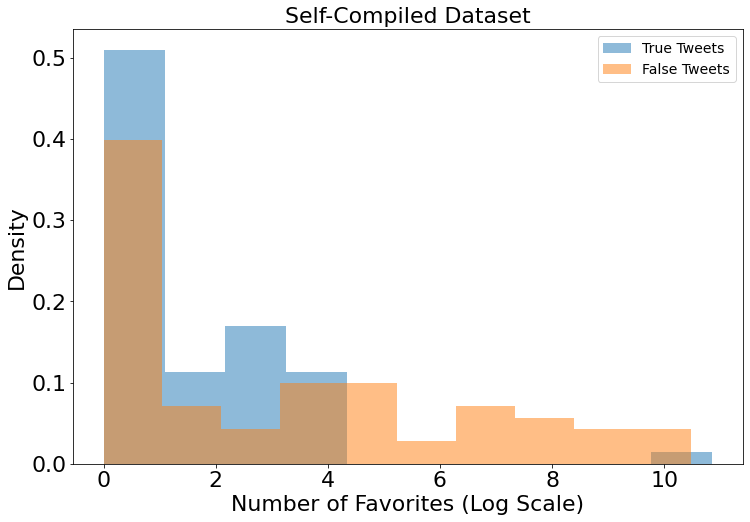

In [74]:
data = [news_true_data[1][2], news_false_data[1][2]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Favorites (Log Scale)",True, "Self-Compiled Dataset")
statistic, pvalue = stats.ttest_ind(news_true_data[0][2], news_false_data[0][2], equal_var=False, alternative='less')
print(pvalue)

m,b = 0.3244214385733673 -1.9141320268127004
m,b = 0.7557229726504043 -2.7365897266042145


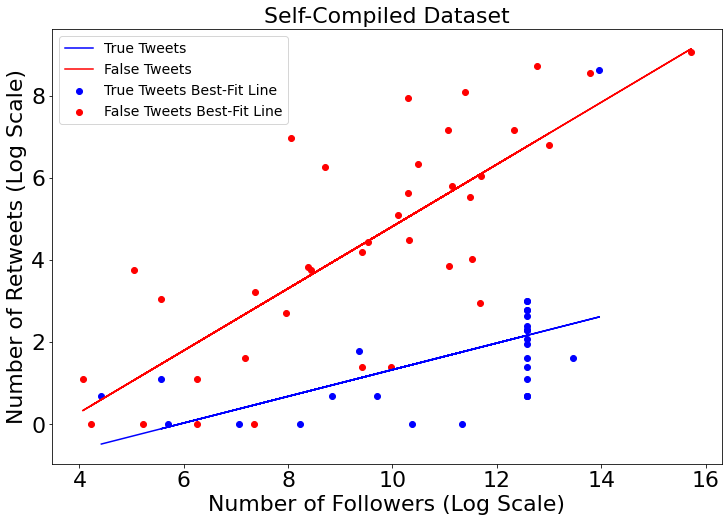

In [158]:
plot_arr = [news_true_data[2][0], news_true_data[2][1]], [news_false_data[2][0], news_false_data[2][1]]
legend = ['True Tweets', 'False Tweets','True Tweets Best-Fit Line', 'False Tweets Best-Fit Line']
plotScatters(plot_arr,'Number of Followers (Log Scale)', 'Number of Retweets (Log Scale)', legend, True, "Self-Compiled Dataset")

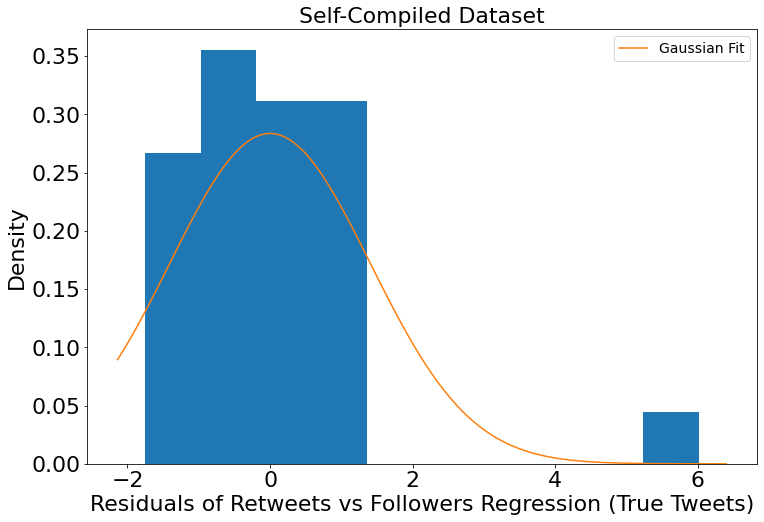

In [165]:
resids = getResiduals(news_true_data[2][0], news_true_data[2][1])
plotHistogram(resids, "Residuals of Retweets vs Followers Regression (True Tweets)", True, True, "Self-Compiled Dataset")

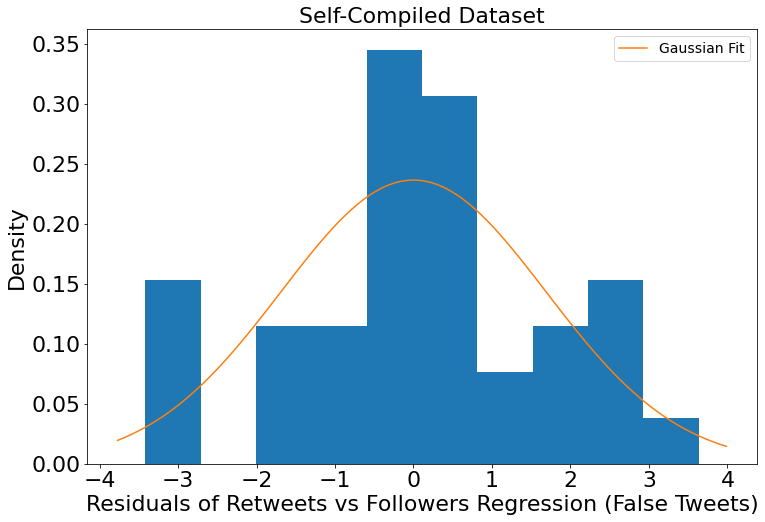

In [166]:
resids = getResiduals(news_false_data[2][0], news_false_data[2][1])
plotHistogram(resids, "Residuals of Retweets vs Followers Regression (False Tweets)", True, True, "Self-Compiled Dataset")

In [26]:
test = runRegression(news_false_data[2][0], news_false_data[2][1])
print()
test = runRegression(news_true_data[2][0], news_true_data[2][1])
print()
test = testSlopeDifference(news_false_data[2][0], news_false_data[2][1], news_true_data[2][0], news_true_data[2][1])

Regression Statistics: 
Slope: 0.75572297
Intercept: -2.73658973
R-squared: 0.59775746
p-value: 0.00000002
Std error: 0.10478765
Slope 95% LB: 0.55033918
Slope 95% UB: 0.96110677

Regression Statistics: 
Slope: 0.32442144
Intercept: -1.91413203
R-squared: 0.25954250
p-value: 0.00476095
Std error: 0.10545653
Slope 95% LB: 0.11772664
Slope 95% UB: 0.53111624

Test statistic: 2.9011475483196896
Standard error: 0.14866583891151677
P-value: 0.0025698676705195734


m,b = 0.3784913904360286 -1.317820891151857
m,b = 0.7958358950018964 -2.323835682468004


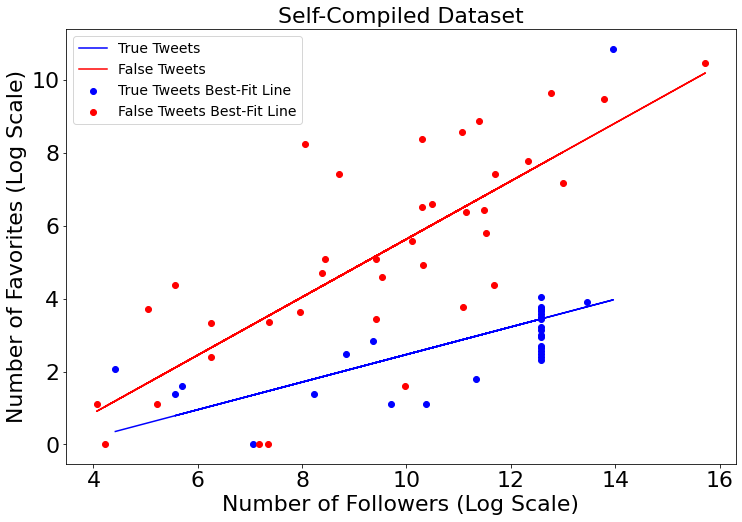

In [159]:
plot_arr = [news_true_data[2][0], news_true_data[2][2]], [news_false_data[2][0], news_false_data[2][2]]
legend = ['True Tweets', 'False Tweets','True Tweets Best-Fit Line', 'False Tweets Best-Fit Line']
plotScatters(plot_arr,'Number of Followers (Log Scale)', 'Number of Favorites (Log Scale)', legend, True, "Self-Compiled Dataset")

In [28]:
test = runRegression(news_false_data[2][0], news_false_data[2][2])
print()
test = runRegression(news_true_data[2][0], news_true_data[2][2])
print()
test =testSlopeDifference(news_false_data[2][0], news_false_data[2][2], news_true_data[2][0], news_true_data[2][2])

Regression Statistics: 
Slope: 0.79583590
Intercept: -2.32383568
R-squared: 0.59544102
p-value: 0.00000002
Std error: 0.11088200
Slope 95% LB: 0.57850717
Slope 95% UB: 1.01316462

Regression Statistics: 
Slope: 0.37849139
Intercept: -1.31782089
R-squared: 0.29408816
p-value: 0.00237341
Std error: 0.11285234
Slope 95% LB: 0.15730080
Slope 95% UB: 0.59968198

Test statistic: 2.6379113824386398
Standard error: 0.15821020650816936
P-value: 0.005266240927501891


m,b = 0.8655569554991123 -0.8088352398029774
m,b = 0.9134019604383076 -0.34261658494456276


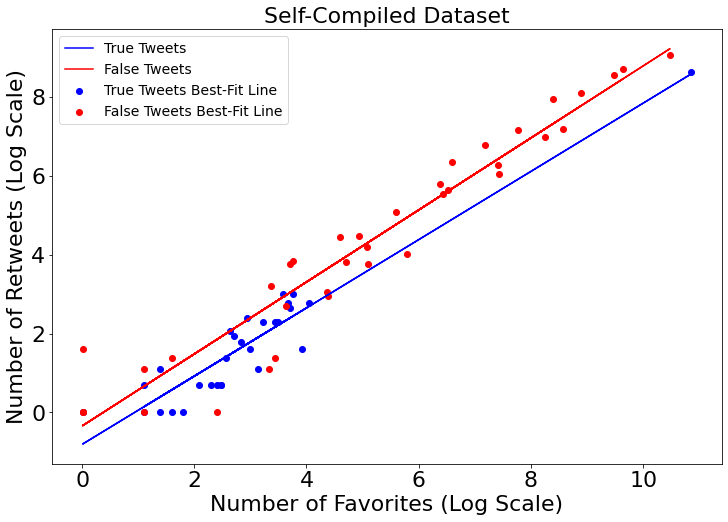

In [163]:
plot_arr = [news_true_data[2][2], news_true_data[2][1]], [news_false_data[2][2], news_false_data[2][1]]
legend = ['True Tweets', 'False Tweets','True Tweets Best-Fit Line', 'False Tweets Best-Fit Line']
plotScatters(plot_arr,'Number of Favorites (Log Scale)', 'Number of Retweets (Log Scale)', legend, True, "Self-Compiled Dataset")

In [167]:
runRegression(news_true_data[2][2], news_true_data[2][1])

Regression Statistics: 
Slope: 0.86555696
Intercept: -0.80883524
R-squared: 0.89994333
p-value: 0.00000000
Std error: 0.05554298
Slope 95% LB: 0.75669271
Slope 95% UB: 0.97442120


[0.8655569554991123,
 -0.8088352398029792,
 0.9486534310615627,
 5.090978000339846e-15,
 0.05554298351469033]

In [169]:
runRegression(news_false_data[2][2], news_false_data[2][1])

Regression Statistics: 
Slope: 0.91340196
Intercept: -0.34261658
R-squared: 0.92882081
p-value: 0.00000000
Std error: 0.04274039
Slope 95% LB: 0.82963080
Slope 95% UB: 0.99717313


[0.9134019604383077,
 -0.3426165849445635,
 0.9637534984593265,
 1.1431991490474709e-21,
 0.04274039025030356]

In [32]:
testSlopeDifference(news_false_data[2][2], news_false_data[2][1], news_true_data[2][2], news_true_data[2][1])

Test statistic: 0.6826810675465559
Standard error: 0.07008397802965671
P-value: 0.2486756707318578


(0.6826810675465559, 0.07008397802965671, 0.2486756707318578)

## POTENTIALLY RELATED TO DEEPER CASCADES

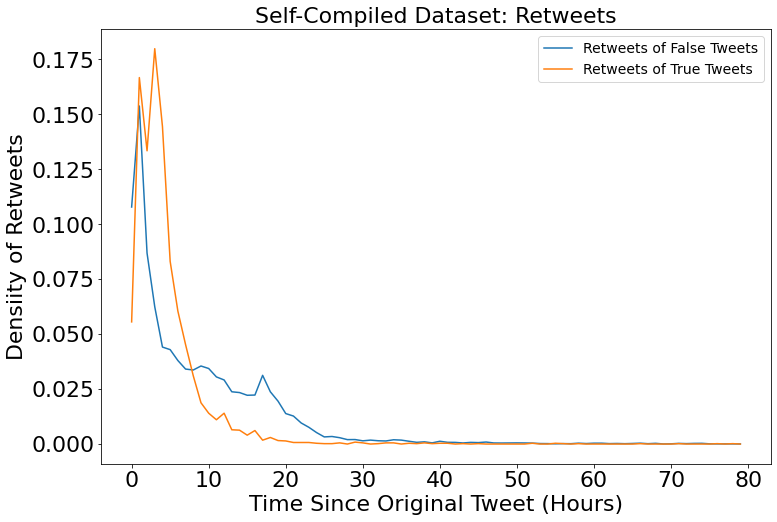

In [81]:
counts_false_time = getCountsTimeSeries("fake_counts")
counts_true_time = getCountsTimeSeries("true_counts")
x = [q for q in range(len(counts_false_time))]
cutoff = 80
plot_arr = [[x[:cutoff],counts_false_time[:cutoff]], 
            [x[:cutoff],counts_true_time[:cutoff]]]
plotLines(plot_arr, "Time Since Original Tweet (Hours)", "Densiity of Retweets",["Retweets of False Tweets", "Retweets of True Tweets"], "Self-Compiled Dataset: Retweets")

# Retweet Analysis

In [84]:
#with open("viral_OG_tweets_5000.pkl", "rb") as f:
true_retweets = pickle5.load(open("true_retweets.pkl", "rb")).reset_index()
false_retweets = pickle5.load(open("fake_retweets_pt1.pkl", "rb")).append(pickle5.load(open("fake_retweets_pt2.pkl", "rb"))).reset_index()

In [85]:
true_retweets_fol = true_retweets['#Followers']
true_retweets_ret = true_retweets['#Retweets']
true_retweets_fav = true_retweets['#Favorites']
true_retweets_data = getFolsFavsAndRetInfo([true_retweets_fol, true_retweets_ret, true_retweets_fav])
false_retweets_fol = false_retweets['#Followers']
false_retweets_ret = false_retweets['#Retweets']
false_retweets_fav = false_retweets['#Favorites']
false_retweets_data = getFolsFavsAndRetInfo([false_retweets_fol, false_retweets_ret, false_retweets_fav])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [211]:
len(data[0]) + len(data[1])

24958

0.028559010028890483


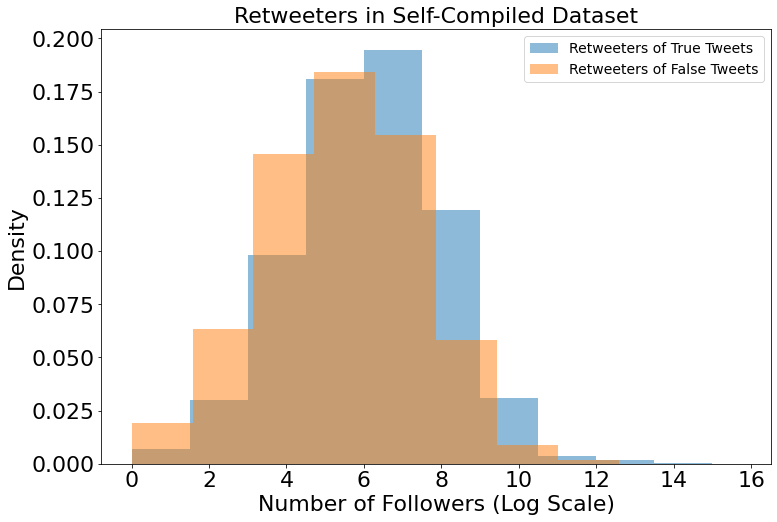

In [207]:
data = [true_retweets_data[1][0], false_retweets_data[1][0]]
labels = ["Retweeters of True Tweets", "Retweeters of False Tweets"]
plotHistograms(data,labels,"Number of Followers (Log Scale)",True, "Retweeters in Self-Compiled Dataset")
statistic, pvalue = stats.ttest_ind(true_retweets_data[0][0], false_retweets_data[0][0], equal_var=False, alternative='two-sided')
print(pvalue)

# User Mentions, Media, Hashtags

In [20]:
df1 = df_true
df2 = df_fake
data1 = getTagsMediaHashtagsInfo(df1, "True News")
data2 = getTagsMediaHashtagsInfo(df2, "False News")
ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
print("Prop_verified true:",ver1['prop_verified'][0])
print("Prop_verified false:",ver2['prop_verified'][0])
print("P-val for prop_verified:",testProportionDifference(ver1['prop_verified'], ver2['prop_verified'], data1['n'], data2['n'])[0])
print("P-val for prop_tagged:",testProportionDifference(data1['prop_tagged'], data2['prop_tagged'], data1['n'], data2['n'])[0])
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
print("P-val for prop_hashtagged:",testProportionDifference(data1['prop_hashtagged'], data2['prop_hashtagged'], data1['n'], data2['n'])[0])
data1.append(data2)

Prop_verified true: 0.4
Prop_verified false: 0.208955223880597
P-val for prop_verified: 0.016950994215555716
P-val for prop_tagged: 0.00011837885166716889
P-val for prop_media: 0.022279734134057996
P-val for prop_hashtagged: 0.7132856961217942


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,True News,65,0.200000,1.000000,0.123077,N/A,N/A,0.092308,2.333333
0,False News,67,0.522388,4.885714,0.283582,N/A,N/A,0.074627,1.000000


In [22]:
df1 = chen_125_OG.reset_index()
df2 = df_shahi_I
data1 = getTagsMediaHashtagsInfo(df1, "Chen Background")
data2 = getTagsMediaHashtagsInfo(df2, "Shahi I")
ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
print("Prop_verified true:",ver1['prop_verified'][0])
print("Prop_verified false:",ver2['prop_verified'][0])
print("P-val for prop_verified:",testProportionDifference(ver1['prop_verified'], ver2['prop_verified'], data1['n'], data2['n'])[0])
print("P-val for prop_tagged:",testProportionDifference(data1['prop_tagged'], data2['prop_tagged'], data1['n'], data2['n'])[0])
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
print("P-val for prop_hashtagged:",testProportionDifference(data1['prop_hashtagged'], data2['prop_hashtagged'], data1['n'], data2['n'])[0])
data1.append(data2)

Prop_verified true: 0.039335394126738796
Prop_verified false: 0.5317139001349528
P-val for prop_verified: 0.0
P-val for prop_tagged: 0.5911223943620622
P-val for prop_media: 0.0
P-val for prop_hashtagged: 2.255903032898409e-55


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,Chen Background,25880,0.367272,1.930984,0.102125,N/A,N/A,0.160355,2.642410
0,Shahi I,741,0.357625,1.735849,0.596491,N/A,N/A,0.377868,2.132143


In [27]:
# df1 = df_shahi_II
# df2 = df_shahi_I
# data1 = getTagsMediaHashtagsInfo(df1, "Shahi II")
# data2 = getTagsMediaHashtagsInfo(df2, "Shahi I")
# ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
# ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
# print("Prop_verified true:",ver1['prop_verified'][0])
# print("Prop_verified false:",ver2['prop_verified'][0])
# print("P-val for prop_verified:",testProportionDifference(ver1['prop_verified'], ver2['prop_verified'], data1['n'], data2['n'])[0])
# print("P-val for prop_tagged:",testProportionDifference(data1['prop_tagged'], data2['prop_tagged'], data1['n'], data2['n'])[0])
# print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
# print("P-val for prop_hashtagged:",testProportionDifference(data1['prop_hashtagged'], data2['prop_hashtagged'], data1['n'], data2['n'])[0])
# data1.append(data2)

In [24]:
df1 = df_ArCOV_real
df2 = df_ArCOV_false
data1 = getTagsMediaHashtagsInfo(df1, "ArCOV Real")
data2 = getTagsMediaHashtagsInfo(df2, "ArCOV False")
ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
print("Prop_verified true:",ver1['prop_verified'][0])
print("Prop_verified false:",ver2['prop_verified'][0])
print("P-val for prop_verified:",testProportionDifference(ver1['prop_verified'], ver2['prop_verified'], data1['n'], data2['n'])[0])
print("P-val for prop_tagged:",testProportionDifference(data1['prop_tagged'], data2['prop_tagged'], data1['n'], data2['n'])[0])
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
print("P-val for prop_hashtagged:",testProportionDifference(data1['prop_hashtagged'], data2['prop_hashtagged'], data1['n'], data2['n'])[0])
data1.append(data2)

Prop_verified true: 0.34103343465045594
Prop_verified false: 0.06159420289855073
P-val for prop_verified: 7.305885962201713e-78
P-val for prop_tagged: 1.4425330222992245e-10
P-val for prop_media: 0.010965539936193033
P-val for prop_hashtagged: 3.851480846113488e-09


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,ArCOV Real,1645,0.184195,1.399340,0.516717,N/A,N/A,0.798784,2.769406
0,ArCOV False,1380,0.101449,1.185714,0.470290,N/A,N/A,0.706522,2.175385


In [224]:
df1 = df_checked_real
df2 = df_checked_false
data1 = getTagsMediaHashtagsInfo(df1, "Checked True")
data2 = getTagsMediaHashtagsInfo(df2, "Checked False")
ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
print("P-val for prop_pic:",testProportionDifference(data1['prop_pic'], data2['prop_pic'], data1['n'], data2['n'])[0])
print("P-val for prop_video:",testProportionDifference(data1['prop_video'], data2['prop_video'], data1['n'], data2['n'])[0])
data1.append(data2)

P-val for prop_media: 1.972284196733425e-161
P-val for prop_pic: 2.739607248195235e-63
P-val for prop_video: 0.6091685278041445


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,Checked True,1772,N/A,N/A,0.968962,0.650113,0.318849,N/A,N/A
0,Checked False,338,N/A,N/A,0.461538,0.156805,0.304734,N/A,N/A


In [26]:
df1 = df_checked_real
df2 = df_checked_false
data1 = getTagsMediaHashtagsInfo(df1, "Checked True")
data2 = getTagsMediaHashtagsInfo(df2, "Checked False")
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
data1.append(data2)

P-val for prop_media: 1.972284196733425e-161


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,Checked True,1772,N/A,N/A,0.968962,0.650113,0.318849,N/A,N/A
0,Checked False,338,N/A,N/A,0.461538,0.156805,0.304734,N/A,N/A


In [28]:
df1 = chen_125_OG.reset_index()
df2 = chen_viral
data1 = getTagsMediaHashtagsInfo(df1, "Chen Background")
data2 = getTagsMediaHashtagsInfo(df2, "Chen Viral")
ver1 = getRetweetsFavsFollowersInfo(df1, 'Test')
ver2 = getRetweetsFavsFollowersInfo(df2, 'Test')
print("Prop_verified true:",ver1['prop_verified'][0])
print("Prop_verified false:",ver2['prop_verified'][0])
print("P-val for prop_verified:",testProportionDifference(ver1['prop_verified'], ver2['prop_verified'], data1['n'], data2['n'])[0])
print("P-val for prop_tagged:",testProportionDifference(data1['prop_tagged'], data2['prop_tagged'], data1['n'], data2['n'])[0])
print("P-val for prop_media:",testProportionDifference(data1['prop_media'], data2['prop_media'], data1['n'], data2['n'])[0])
print("P-val for prop_hashtagged:",testProportionDifference(data1['prop_hashtagged'], data2['prop_hashtagged'], data1['n'], data2['n'])[0])
data1.append(data2)

Prop_verified true: 0.039335394126738796
Prop_verified false: 0.26
P-val for prop_verified: 3.4706469296218614e-29
P-val for prop_tagged: 1.332352133526205e-13
P-val for prop_media: 5.7892713580333175e-06
P-val for prop_hashtagged: 0.00038493600809940955


,Name,n,prop_tagged,avg_num_tags,prop_media,prop_pic,prop_video,prop_hashtagged,avg_num_hashtags
0,Chen Background,25880,0.367272,1.930984,0.102125,N/A,N/A,0.160355,2.642410
0,Chen Viral,100,0.010000,1.000000,0.240000,N/A,N/A,0.030000,1.333333


## Other Datasets

In [12]:
ArCOV_real_fol = df_ArCOV_real['#Followers']
ArCOV_real_ret = df_ArCOV_real['#Retweets']
ArCOV_real_fav = df_ArCOV_real['#Favorites']
ArCOV_false_fol = df_ArCOV_false['#Followers']
ArCOV_false_ret = df_ArCOV_false['#Retweets']
ArCOV_false_fav = df_ArCOV_false['#Favorites']
ArCOV_real_data = getFolsFavsAndRetInfo([ArCOV_real_fol, ArCOV_real_ret, ArCOV_real_fav])
ArCOV_false_data = getFolsFavsAndRetInfo([ArCOV_false_fol, ArCOV_false_ret, ArCOV_false_fav])

checked_real_com = df_checked_real['#Comments']
checked_real_ret = df_checked_real['#Retweets']
checked_real_fav = df_checked_real['#Favorites']
checked_false_com = df_checked_false['#Comments']
checked_false_ret = df_checked_false['#Retweets']
checked_false_fav = df_checked_false['#Favorites']
checked_real_data = getFolsFavsAndRetInfo([checked_real_com, checked_real_ret, checked_real_fav])
checked_false_data = getFolsFavsAndRetInfo([checked_false_com, checked_false_ret, checked_false_fav])

shahi_II_fol = df_shahi_II['#Followers']
shahi_II_ret = df_shahi_II['#Retweets']
shahi_II_fav = df_shahi_II['#Favorites']
shahi_I_fol = df_shahi_I['#Followers']
shahi_I_ret = df_shahi_I['#Retweets']
shahi_I_fav = df_shahi_I['#Favorites']
shahi_II_data = getFolsFavsAndRetInfo([shahi_II_fol, shahi_II_ret, shahi_II_fav])
shahi_I_data = getFolsFavsAndRetInfo([shahi_I_fol, shahi_I_ret, shahi_I_fav])

# Haouari's Dataset

7.582730593074181e-19


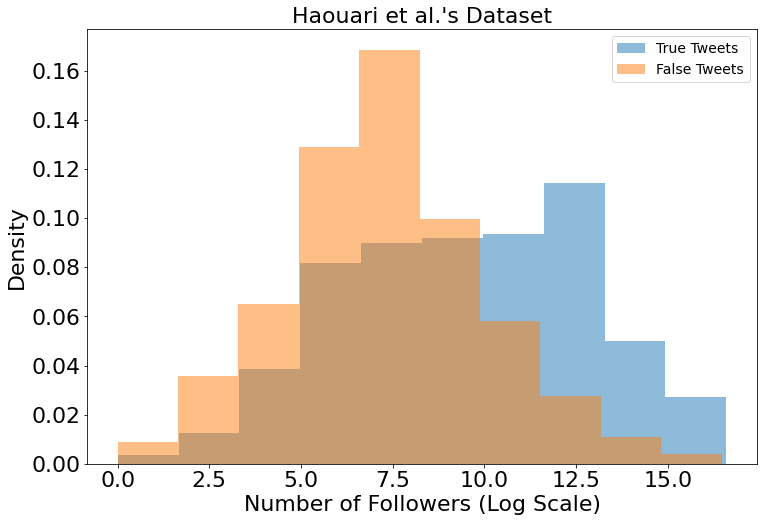

In [233]:
data = [ArCOV_real_data[1][0], ArCOV_false_data[1][0]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Followers (Log Scale)",True, "Haouari et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(ArCOV_real_data[0][0], ArCOV_false_data[0][0], equal_var=False, alternative='greater')
print(pvalue)

0.0036529575036324383


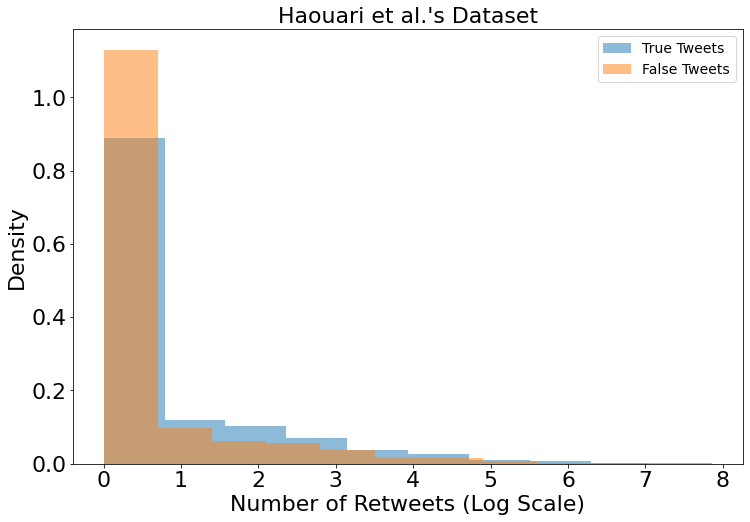

In [234]:
data = [ArCOV_real_data[1][1], ArCOV_false_data[1][1]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Retweets (Log Scale)",True, "Haouari et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(ArCOV_real_data[0][1], ArCOV_false_data[0][1], equal_var=False, alternative='greater')
print(pvalue)

0.019935340756658315


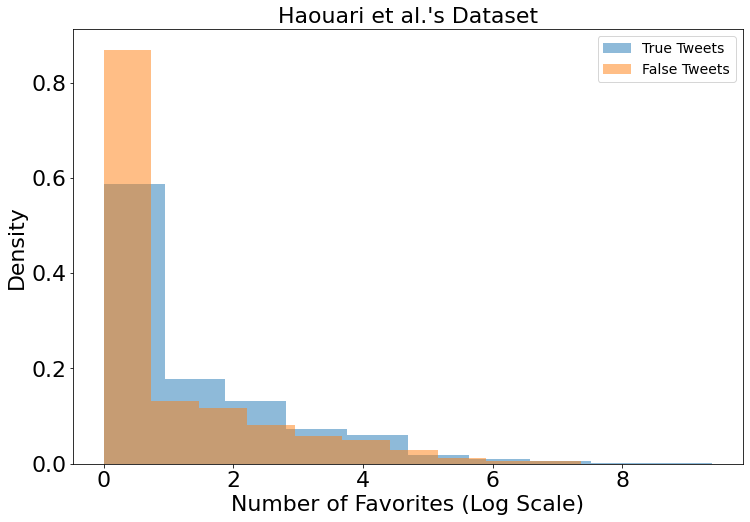

In [235]:
data = [ArCOV_real_data[1][2], ArCOV_false_data[1][2]]
labels = ["True Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Favorites (Log Scale)",True, "Haouari et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(ArCOV_real_data[0][2], ArCOV_false_data[0][2], equal_var=False, alternative='greater')
print(pvalue)

m,b = 0.16417327525746475 -0.28765679790627563
m,b = 0.16870227972868662 -0.17635772974793584
Test statistic: 0.16374337622221805
Standard error: 0.027659161400675904
P-value: 0.43497885756556603


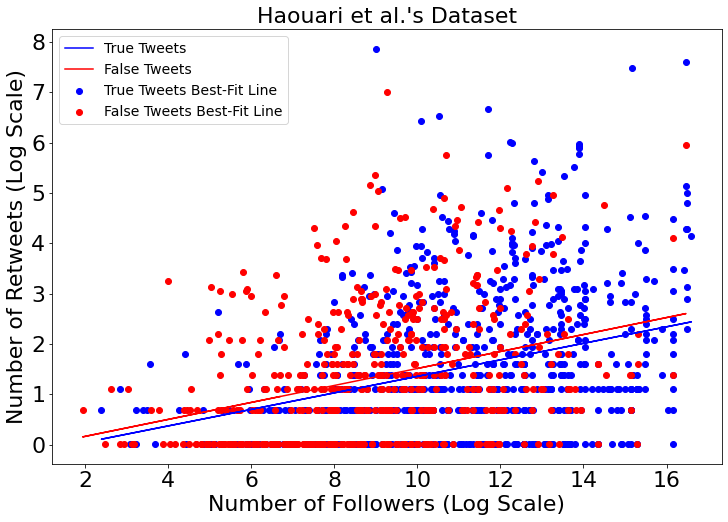

In [236]:
plot_arr = [ArCOV_real_data[2][0], ArCOV_real_data[2][1]], [ArCOV_false_data[2][0], ArCOV_false_data[2][1]]
legend = ['True Tweets', 'False Tweets','True Tweets Best-Fit Line', 'False Tweets Best-Fit Line']
plotScatters(plot_arr,'Number of Followers (Log Scale)', 'Number of Retweets (Log Scale)', legend, True, "Haouari et al.'s Dataset")
test = testSlopeDifference(ArCOV_false_data[2][0], ArCOV_false_data[2][1], ArCOV_real_data[2][0], ArCOV_real_data[2][1])

# Shahi's Dataset

1.1416962653610687e-08


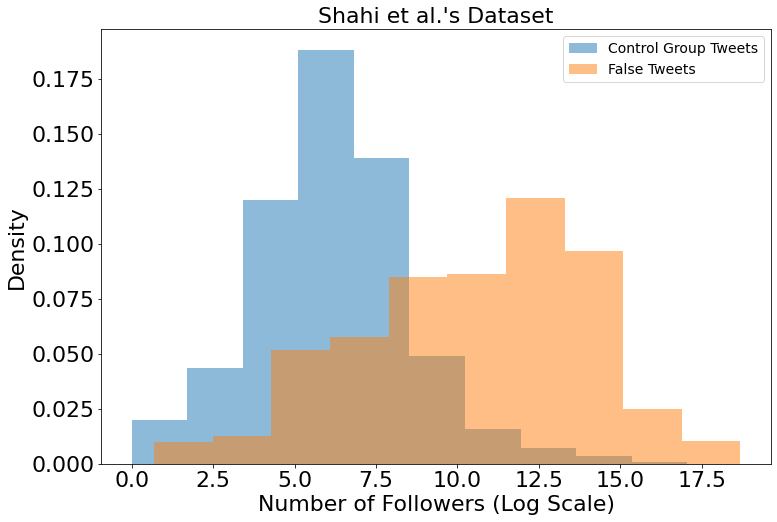

In [237]:
data = [chen_data[1][0], shahi_I_data[1][0]]
labels = ["Control Group Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Followers (Log Scale)",True, "Shahi et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(chen_data[0][0], shahi_I_data[0][0], equal_var=False, alternative='less')
print(pvalue)

3.0650311699658074e-09


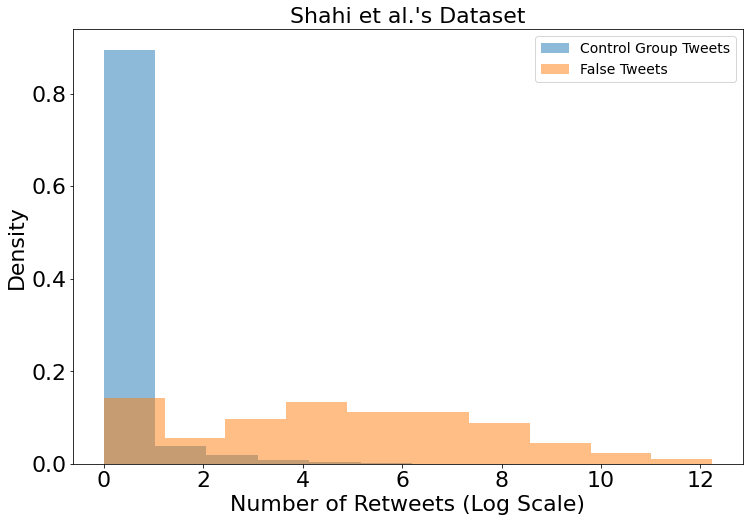

In [238]:
data = [chen_data[1][1], shahi_I_data[1][1]]
labels = ["Control Group Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Retweets (Log Scale)",True, "Shahi et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(chen_data[0][1], shahi_I_data[0][1], equal_var=False, alternative='less')
print(pvalue)

3.916462703268745e-06


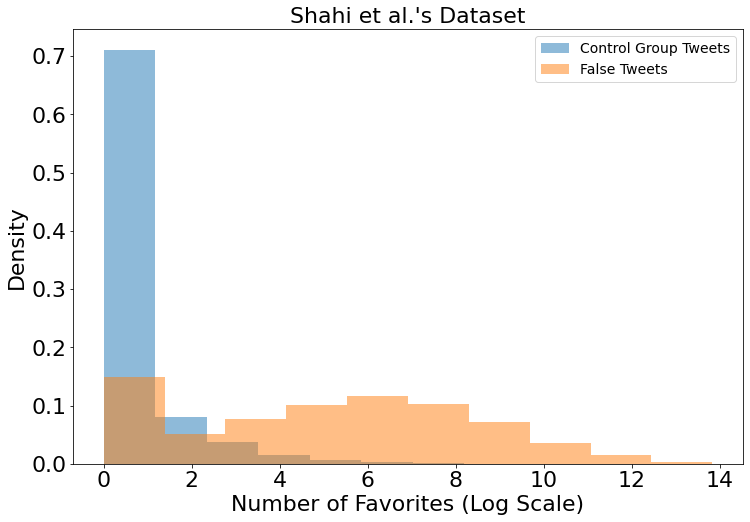

In [239]:
data = [chen_data[1][2], shahi_I_data[1][2]]
labels = ["Control Group Tweets", "False Tweets"]
plotHistograms(data,labels,"Number of Favorites (Log Scale)",True, "Shahi et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(chen_data[0][2], shahi_I_data[0][2], equal_var=False, alternative='less')
print(pvalue)

m,b = 0.2110633531660492 -0.6676747872998199
m,b = 0.42642045820531244 0.3520821399176647
Test statistic: 6.8615079681659745
Standard error: 0.031386264657625486
P-value: 3.821673320513315e-12


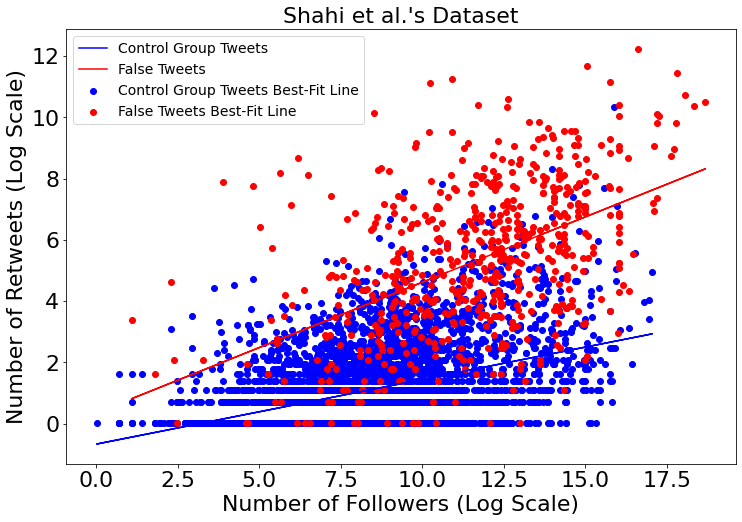

In [240]:
plot_arr = [chen_data[2][0], chen_data[2][1]], [shahi_I_data[2][0], shahi_I_data[2][1]]
legend = ['Control Group Tweets', 'False Tweets','Control Group Tweets Best-Fit Line', 'False Tweets Best-Fit Line']
plotScatters(plot_arr,'Number of Followers (Log Scale)', 'Number of Retweets (Log Scale)', legend, True, "Shahi et al.'s Dataset")
test = testSlopeDifference(shahi_I_data[2][0], shahi_I_data[2][1], chen_data[2][0], chen_data[2][1])

# Yang's Dataset

0.0008892093518856028


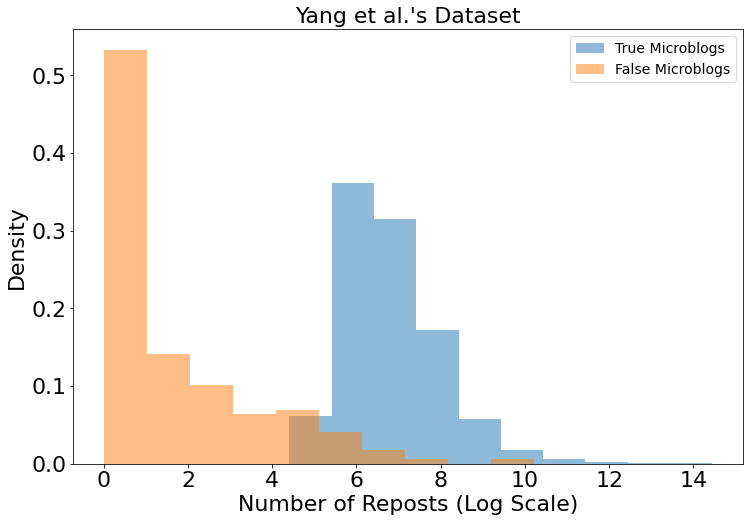

In [241]:
data = [checked_real_data[1][1], checked_false_data[1][1]]
labels = ["True Microblogs", "False Microblogs"]
plotHistograms(data,labels,"Number of Reposts (Log Scale)",True, "Yang et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(checked_real_data[0][1], checked_false_data[0][1], equal_var=False, alternative='greater')
print(pvalue)

1.851854082431929e-45


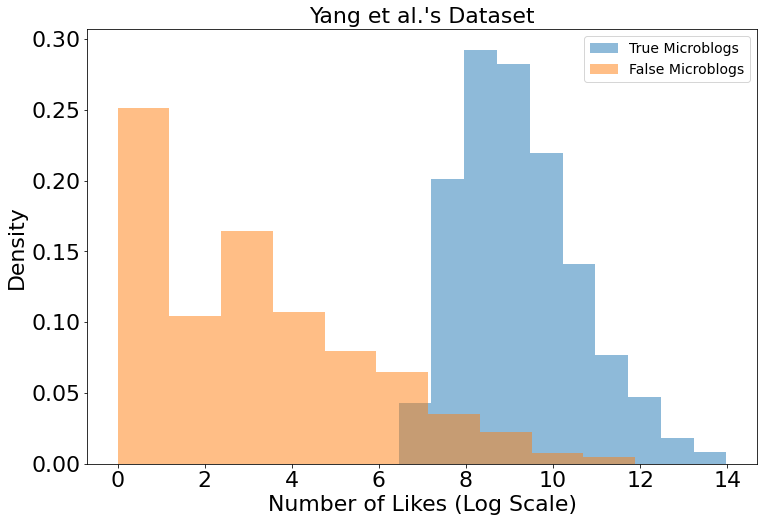

In [242]:
data = [checked_real_data[1][2], checked_false_data[1][2]]
labels = ["True Microblogs", "False Microblogs"]
plotHistograms(data,labels,"Number of Likes (Log Scale)",True, "Yang et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(checked_real_data[0][2], checked_false_data[0][2], equal_var=False, alternative='greater')
print(pvalue)

7.359156048352507e-88


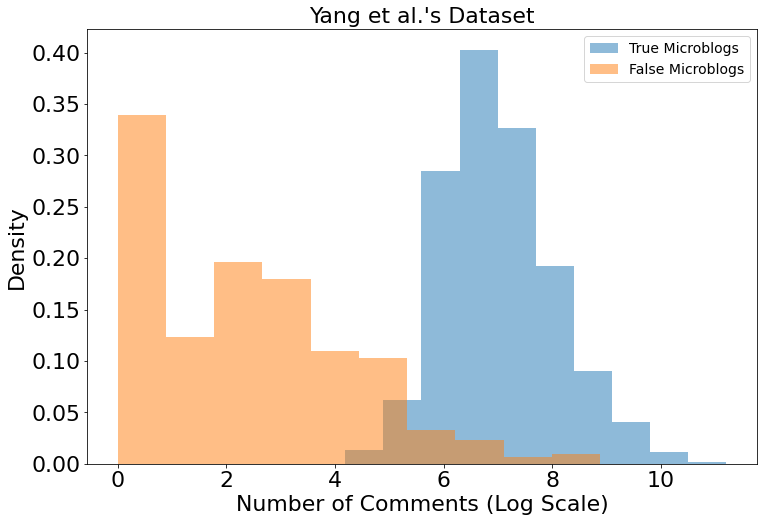

In [222]:
data = [checked_real_data[1][0], checked_false_data[1][0]]
labels = ["True Microblogs", "False Microblogs"]
plotHistograms(data,labels,"Number of Comments (Log Scale)",True, "Yang et al.'s Dataset")
statistic, pvalue = stats.ttest_ind(checked_real_data[0][0], checked_false_data[0][0], equal_var=False, alternative='greater')
print(pvalue)

## Sentiment Analysis

In [13]:
from fn import sortDictByValue, countPOSProportions, getSentimentPolarity, getSentimentSubjectivity, getArrPercentile, sentimentAnalysis

P-val (polarity): 0.6251260861141608
P-val (subjectivity): 0.30073516609443257


,Name,Avg polarity,Std polarity,5th perc. polarity,95th perc. polarity,Avg subjectivity
0,True News,0.064686,0.219638,-0.25,0.466667,0.364594
0,Fake News,0.044163,0.257165,-0.30,0.500000,0.307286


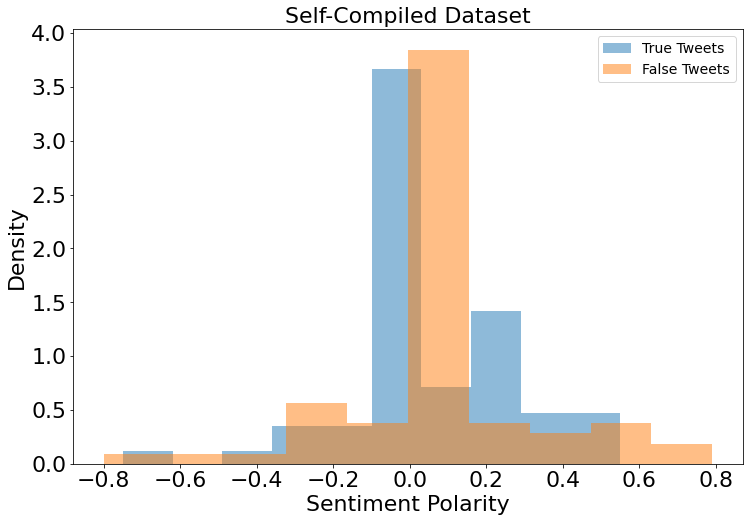

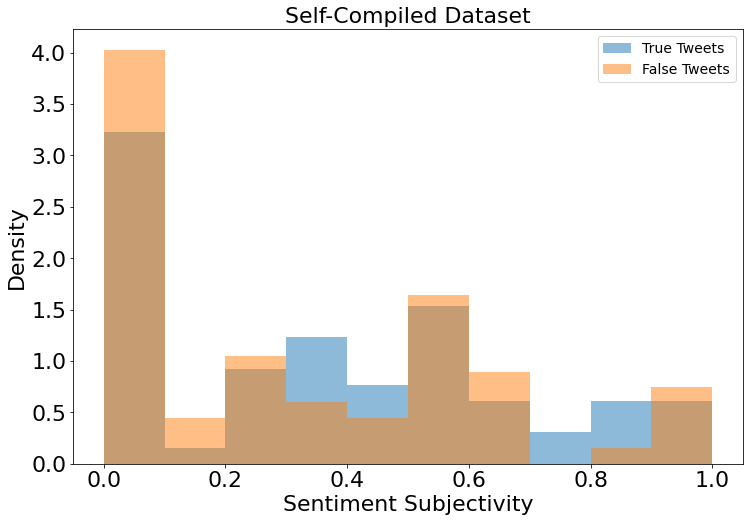

In [182]:
df1 = df_true
df2 = df_fake
df1_text = df1['text'].tolist()
df2_text = df2['text'].tolist()
sent1 = getSentimentPolarity(df1_text)
sent2 = getSentimentPolarity(df2_text)
sub1 = getSentimentSubjectivity(df1_text)
sub2 = getSentimentSubjectivity(df2_text)
data = [sent1, sent2]
data2 = [sub1, sub2]
labels = ["True Tweets", "False Tweets"]
statistic, pvalue = stats.ttest_ind(sent1, sent2, equal_var=False, alternative='two-sided')
print("P-val (polarity):",pvalue)
statistic, pvalue = stats.ttest_ind(sub1, sub2, equal_var=False, alternative='two-sided')
print("P-val (subjectivity):",pvalue)
plotHistograms(data,labels,"Sentiment Polarity",True, "Self-Compiled Dataset")
plotHistograms(data2,labels,"Sentiment Subjectivity",True, "Self-Compiled Dataset")
sentimentAnalysis(df1_text, "True News").append(sentimentAnalysis(df2_text, "Fake News"))

P-val (polarity): 0.06546475495714237
P-val (subjectivity): 0.038418777711159174


,Name,Avg polarity,Std polarity,5th perc. polarity,95th perc. polarity,Avg subjectivity
0,Control Group Tweets,0.030474,0.214072,-0.283333,0.416667,0.228493
0,Viral Tweets,0.068563,0.203044,-0.120000,0.500000,0.295774


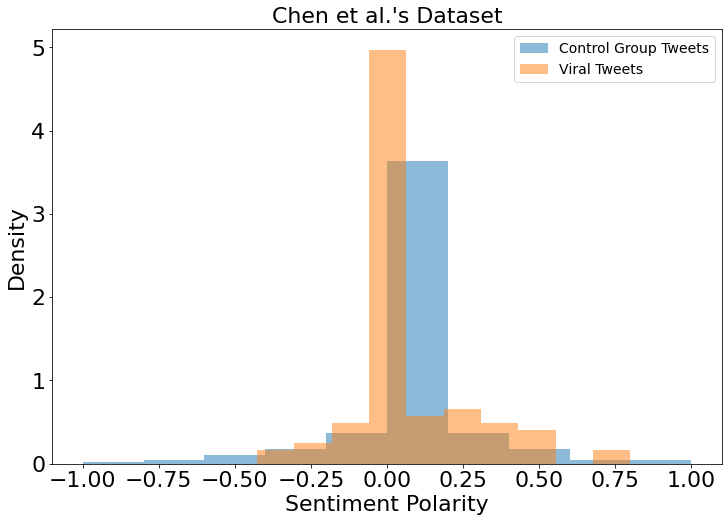

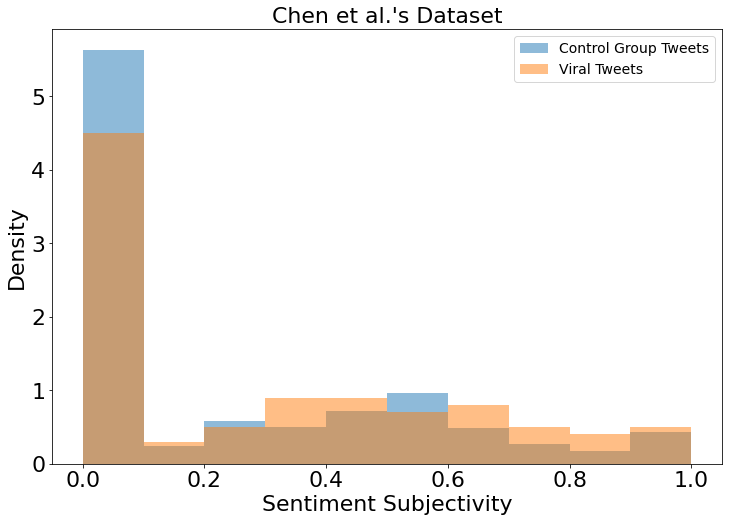

In [243]:
df1 = chen_125_OG
df2 = chen_viral
df1_text = df1['text'].tolist()
df2_text = df2['text'].tolist()
sent1 = getSentimentPolarity(df1_text)
sent2 = getSentimentPolarity(df2_text)
sub1 = getSentimentSubjectivity(df1_text)
sub2 = getSentimentSubjectivity(df2_text)
data = [sent1, sent2]
data2 = [sub1, sub2]
labels = ["Control Group Tweets", "Viral Tweets"]
statistic, pvalue = stats.ttest_ind(sent1, sent2, equal_var=False, alternative='two-sided')
print("P-val (polarity):",pvalue)
statistic, pvalue = stats.ttest_ind(sub1, sub2, equal_var=False, alternative='two-sided')
print("P-val (subjectivity):",pvalue)
plotHistograms(data,labels,"Sentiment Polarity",True, "Chen et al.'s Dataset")
plotHistograms(data2,labels,"Sentiment Subjectivity",True, "Chen et al.'s Dataset")
sentimentAnalysis(df1_text, "Control Group Tweets").append(sentimentAnalysis(df2_text, "Viral Tweets"))

P-val (polarity): 0.19879034573010423
P-val (subjectivity): 0.17196829025506302


,Name,Avg polarity,Std polarity,5th perc. polarity,95th perc. polarity,Avg subjectivity
0,Control Group Tweets,0.030474,0.214072,-0.283333,0.416667,0.228493
0,False Tweets,0.022086,0.173679,-0.233333,0.339394,0.213160


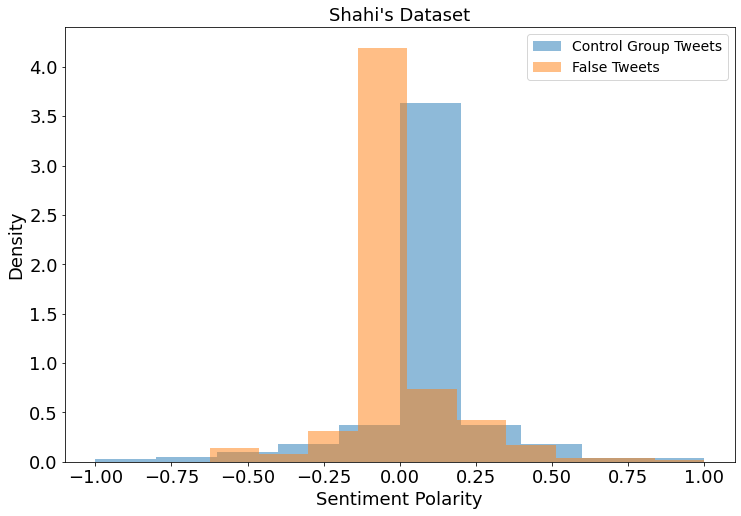

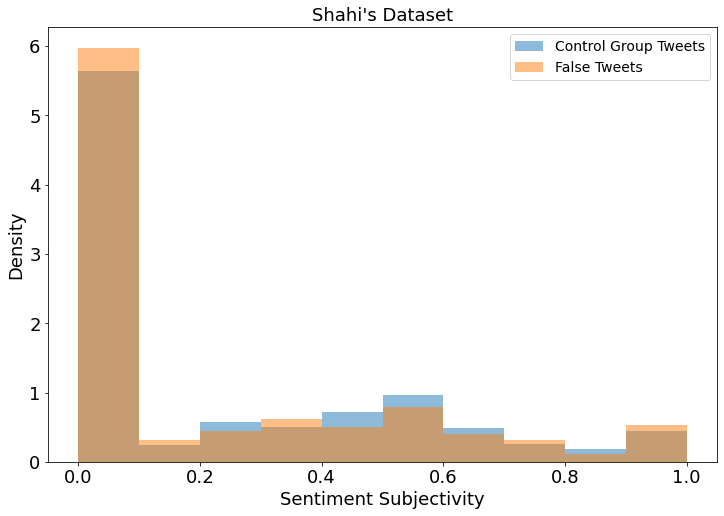

In [30]:
df1 = chen_125_OG
df2 = df_shahi_I
df1_text = df1['text'].tolist()
df2_text = df2['text'].tolist()
sent1 = getSentimentPolarity(df1_text)
sent2 = getSentimentPolarity(df2_text)
sub1 = getSentimentSubjectivity(df1_text)
sub2 = getSentimentSubjectivity(df2_text)
data = [sent1, sent2]
data2 = [sub1, sub2]
labels = ["Control Group Tweets", "False Tweets"]
statistic, pvalue = stats.ttest_ind(sent1, sent2, equal_var=False, alternative='two-sided')
print("P-val (polarity):",pvalue)
statistic, pvalue = stats.ttest_ind(sub1, sub2, equal_var=False, alternative='two-sided')
print("P-val (subjectivity):",pvalue)
plotHistograms(data,labels,"Sentiment Polarity",True, "Shahi's Dataset")
plotHistograms(data2,labels,"Sentiment Subjectivity",True, "Shahi's Dataset")
sentimentAnalysis(df1_text, "Control Group Tweets").append(sentimentAnalysis(df2_text, "False Tweets"))

# Sentiment Analysis v2

In [203]:
def plotPolarityAndSubjectivity(df1, df2, labels, dataset_name, patwa=False):
    if patwa: # make an exception for Patwa's dataset, which is already in text form
        df1_text = df1
        df2_text = df2
    else:
        df1_text = df1['text'].tolist()
        df2_text = df2['text'].tolist()
    sent1 = getNLTKPolarity(df1_text)
    sent2 = getNLTKPolarity(df2_text)
    sub1 = getSentimentSubjectivity(df1_text)
    sub2 = getSentimentSubjectivity(df2_text)
    data = [sent1[3], sent2[3]]
    data2 = [sub1, sub2]
    plotHistograms(data,labels,"Sentiment Polarity",True, dataset_name)
    plotHistograms(data2,labels,"Sentiment Subjectivity",True, dataset_name)
    arr = ['neg:', 'neu:', 'pos:', 'comp:']
    for i in range(len(arr)):
        print(arr[i])
        print("Mean scores:", np.mean(sent1[i]), np.mean(sent2[i]))
        statistic, pvalue = stats.ttest_ind(sent1[i], sent2[i], equal_var=False, alternative='two-sided')
        print("P-val (polarity):", pvalue)
        print()
    statistic, pvalue = stats.ttest_ind(sub1, sub2, equal_var=False, alternative='two-sided')
    print("subjectivity:")
    print("Mean scores:", np.mean(sub1), np.mean(sub2))
    print("P-val (subjectivity):",pvalue)

neg:
Mean scores: 0.06766418083462132 0.07615999999999999
P-val (polarity): 0.4160062840476466

neu:
Mean scores: 0.8732950154559506 0.8349599999999999
P-val (polarity): 0.010754671054906056

pos:
Mean scores: 0.05903918083462133 0.08888000000000001
P-val (polarity): 0.008665796704911547

comp:
Mean scores: -0.022486514683153016 0.006902999999999989
P-val (polarity): 0.5156216773258957

subjectivity:
Mean scores: 0.22849253694413948 0.2957741642616643
P-val (subjectivity): 0.038418777711159174


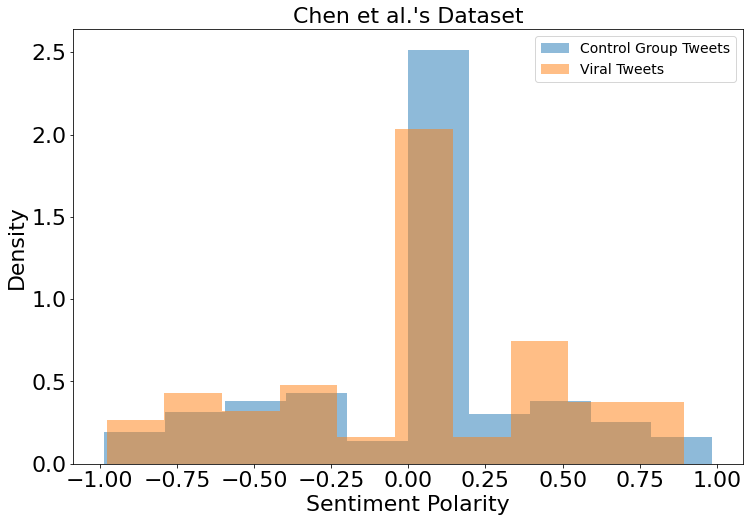

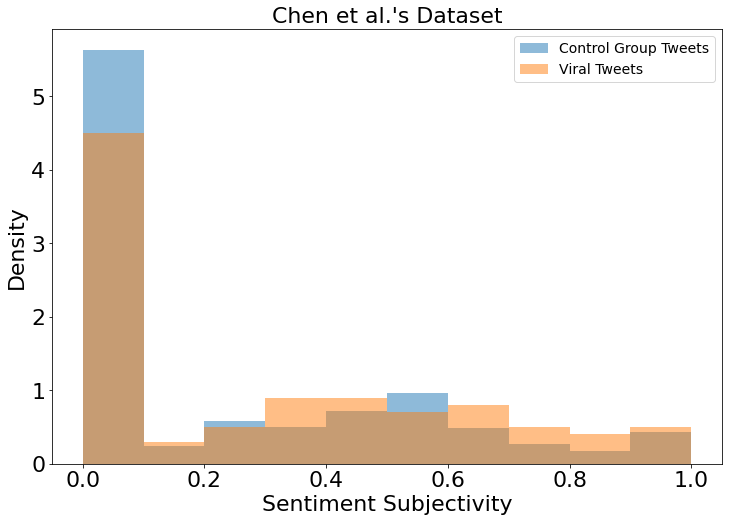

In [244]:
df1 = chen_125_OG
df2 = chen_viral
labels = ["Control Group Tweets", "Viral Tweets"]
dataset_name = "Chen et al.'s Dataset"
plotPolarityAndSubjectivity(df1, df2, labels, dataset_name)

neg:
Mean scores: 0.05887692307692308 0.09902985074626865
P-val (polarity): 0.03694498103269102

neu:
Mean scores: 0.8746461538461539 0.8603134328358208
P-val (polarity): 0.5384594034282979

pos:
Mean scores: 0.0664923076923077 0.04067164179104477
P-val (polarity): 0.09084523354828834

comp:
Mean scores: 0.02061076923076923 -0.16945074626865672
P-val (polarity): 0.008170130388677685

subjectivity:
Mean scores: 0.3645939708439708 0.3072858496632484
P-val (subjectivity): 0.30073516609443257


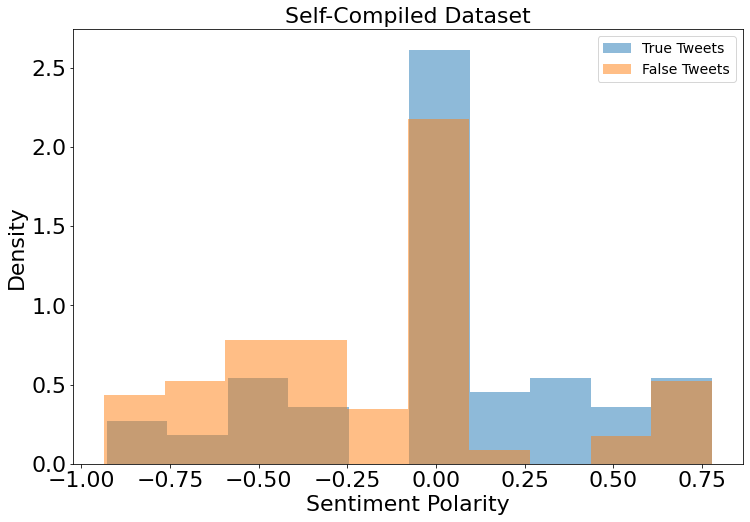

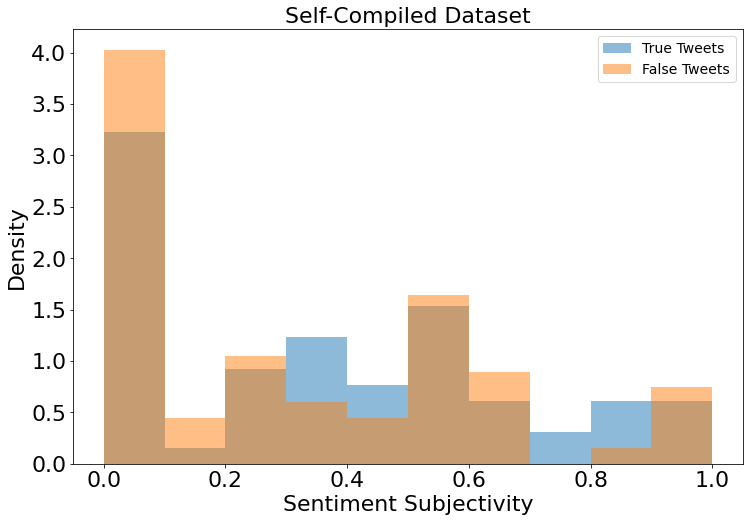

In [193]:
df1 = df_true
df2 = df_fake
labels = ["True Tweets", "False Tweets"]
dataset_name = "Self-Compiled Dataset"
plotPolarityAndSubjectivity(df1, df2, labels, dataset_name)

neg:
Mean scores: 0.06766418083462132 0.046499325236167344
P-val (polarity): 1.704644180109572e-11

neu:
Mean scores: 0.8732950154559506 0.9116464237516869
P-val (polarity): 8.914952536806933e-17

pos:
Mean scores: 0.05903918083462133 0.041850202429149795
P-val (polarity): 6.3311817754967064e-09

comp:
Mean scores: -0.022486514683153016 -0.025568960863697712
P-val (polarity): 0.820770763862282

subjectivity:
Mean scores: 0.22849253694413948 0.21315959790215136
P-val (subjectivity): 0.17196829025506302


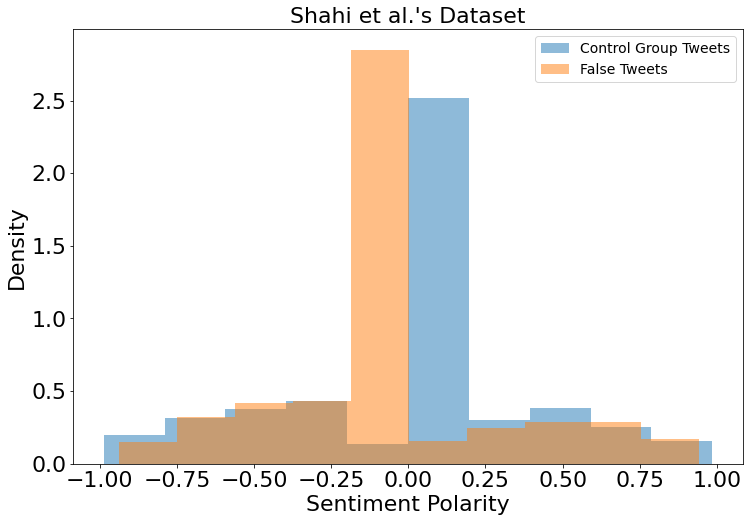

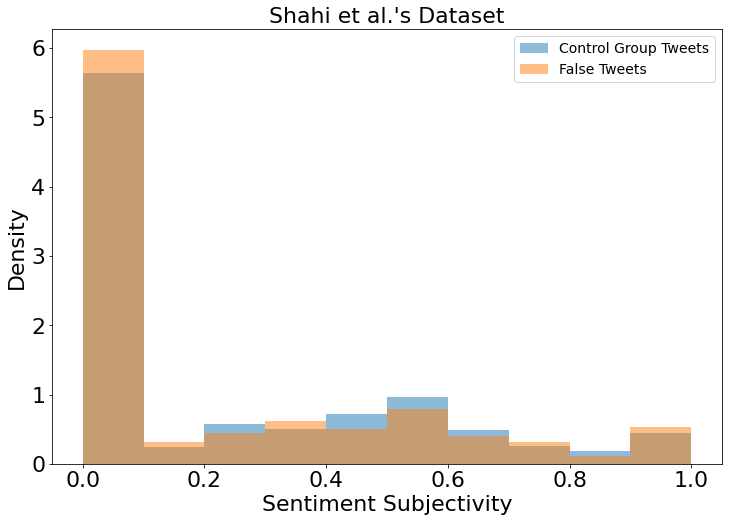

In [245]:
df1 = chen_125_OG
df2 = df_shahi_I
labels = ["Control Group Tweets", "False Tweets"]
dataset_name = "Shahi et al.'s Dataset"
plotPolarityAndSubjectivity(df1, df2, labels, dataset_name)

neg:
Mean scores: 0.04609892857142857 0.08559529411764706
P-val (polarity): 2.2798125894853817e-95

neu:
Mean scores: 0.8886739285714287 0.8512480392156863
P-val (polarity): 2.0628337485519644e-57

pos:
Mean scores: 0.06521892857142857 0.06315490196078433
P-val (polarity): 0.21151757413318215

comp:
Mean scores: 0.07442303571428571 -0.06068554901960785
P-val (polarity): 6.173686213248016e-63

subjectivity:
Mean scores: 0.42463369774774185 0.2792143712924959
P-val (subjectivity): 4.343647014364457e-161


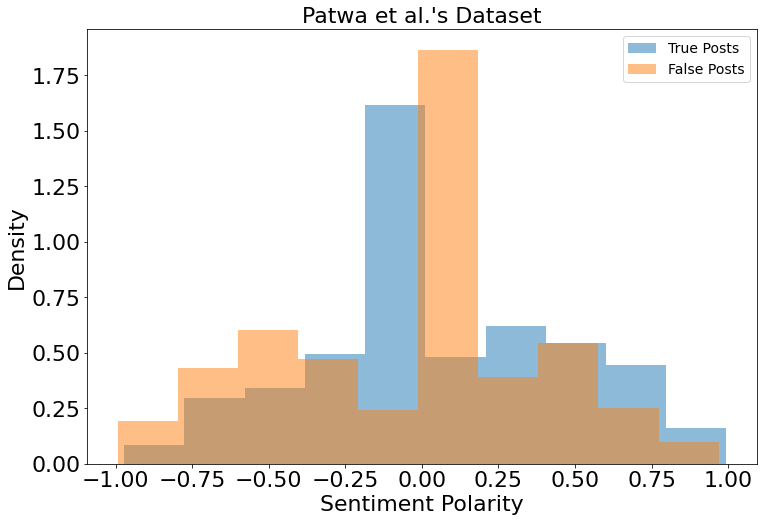

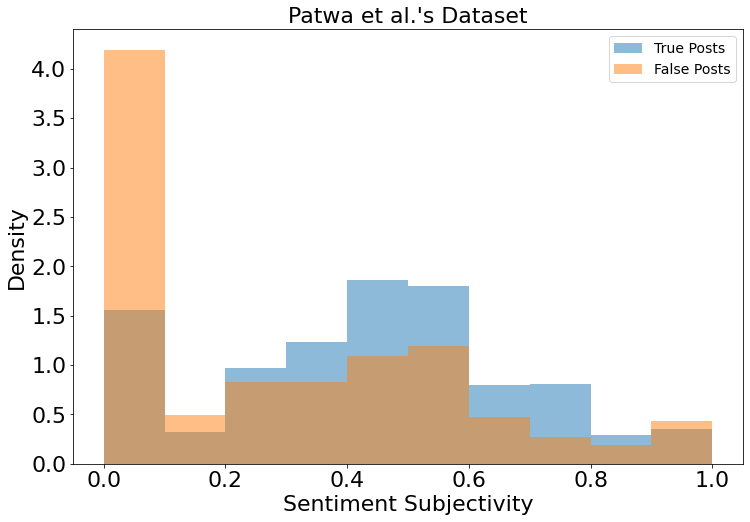

In [246]:
df1 = patwa_real_text
df2 = patwa_fake_text
labels = ["True Posts", "False Posts"]
dataset_name = "Patwa et al.'s Dataset"
plotPolarityAndSubjectivity(df1, df2, labels, dataset_name, True)